<a href="https://colab.research.google.com/github/Jaseelkt007/Generative_AI_basics/blob/main/Langvin_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Langevin sampling
* Langevin sampling is a way to generate samples from a probability distribution p(x), when you can't directly sample from it but you can compute how fast it goes up or down (from its gradient).

Lets suppose we are blindfolded and walking on a hill landscape
  * The shape of hill = gradient
  * feel the which direction is uphill (gradient direction - ascent or descent)
  * but you also take random steps to explore more

This process helps you explore the shape of the hill, and over time, your position ends up being samples from the distribution p(x)

xt+1 = xt + epsilon/2 * d/dx(log(p(xt))) + sqrt(epsilon)*zt    (adding this random noise for exploration and not to stuck at the maxima or minima)
  * zt = noise ~ N(0,1)
  * epsilon = step size
  * sqrt(epsilon)*zt = adds randomness


In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image

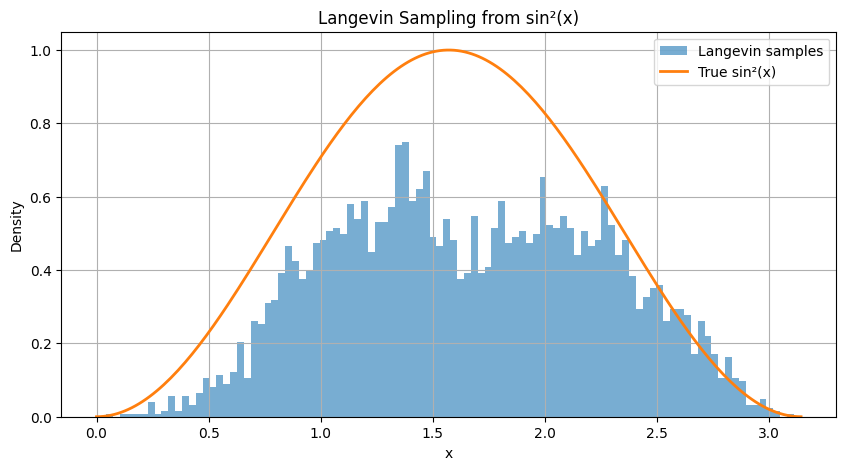

In [ ]:
 # Example : sample from sine distribution


def p_unnormalized(x):
    return np.sin(x)**2 # p(x) ~ sin^2(x) , defined on [0,pi]
    # return np.cos(x)

# d/dx of log(sin^2) = 2 cos(x)/sin(x)
def log_p(x):
    return np.log(np.sin(x)**2 + 1e-8)
    # return np.log(np.cos(x) + 1e-8)

def grad_log_p(x):
    return  2* np.cos(x) / (np.sin(x) + 1e-8)
    # return -np.sin(x) / (np.cos(x) +1e-8)

# Sampling parameters
epsilon = 0.01
num_steps = 5000
burn_in = 1000 # ignore first few steps as warm ups

x = np.random.uniform(0.1, np.pi -0.1) # starting point (avoid 0, pi)
samples = []

# Langevin sampling loop
for i in range(num_steps):
    grad = grad_log_p(x)
    noise = np.sqrt(epsilon)* np.random.randn() # gaussian noise
    x = x + 0.5 *epsilon*grad + noise

    if x < 0:
        x = -x
    elif x > np.pi:
        x = 2 * np.pi - x

    if i > burn_in:
        samples.append(x)

xs = np.linspace(0, np.pi , 200)
true_dist = p_unnormalized(xs)
# true_dist /= np.sum(true_dist)

# plot
plt.figure(figsize=(10,5))
plt.hist(samples, bins=100, density=True, alpha = 0.6, label="Langevin samples")
plt.plot(xs, true_dist, label='True sin²(x)', linewidth=2)
plt.title("Langevin Sampling from sin²(x)")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Consider P(x) = mixture of 2 guassian distribution(1D)
def p_unnormalized(x):
    gauss1 = np.exp(-0.5 * ((x + 2) / 0.5)**2) / (0.5 * np.sqrt(2 * np.pi))
    gauss2 = np.exp(-0.5 * ((x - 2) / 0.5)**2) / (0.5 * np.sqrt(2 * np.pi))
    return 0.5 * gauss1 + 0.5 * gauss2

def log_p(x):
    # Use log-sum-exp trick for numerical stability
    a = -0.5 * ((x + 2)/0.5)**2 - np.log(0.5 * 0.5 * np.sqrt(2 * np.pi))
    b = -0.5 * ((x - 2)/0.5)**2 - np.log(0.5 * 0.5 * np.sqrt(2 * np.pi))
    max_ab = np.maximum(a, b)
    return max_ab + np.log(np.exp(a - max_ab) + np.exp(b - max_ab))

def grad_log_p(x):
    # Compute gradients of each Gaussian component
    gauss1 = np.exp(-0.5 * ((x + 2) / 0.5)**2)
    gauss2 = np.exp(-0.5 * ((x - 2) / 0.5)**2)

    # Derivatives of each component
    d_gauss1 = -((x + 2) / (0.5**2)) * gauss1
    d_gauss2 = -((x - 2) / (0.5**2)) * gauss2

    numerator = 0.5 * d_gauss1 + 0.5 * d_gauss2
    denominator = 0.5 * gauss1 + 0.5 * gauss2 + 1e-8  # avoid divide by 0
    return numerator / denominator

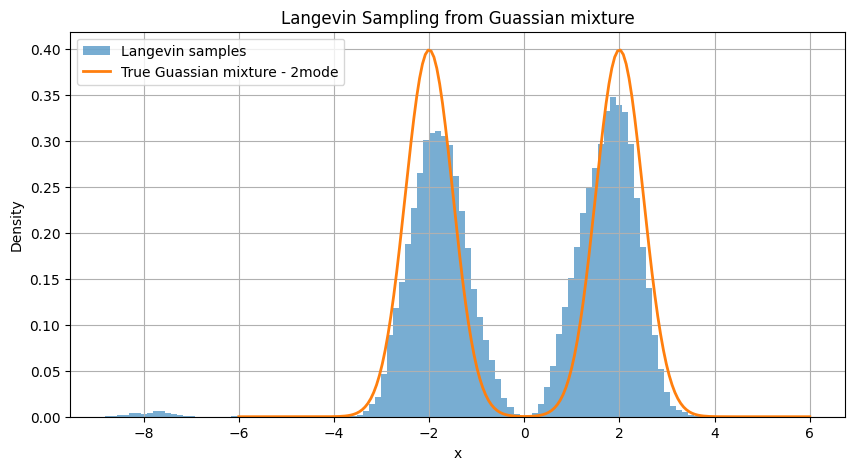

In [ ]:
# Langevin sampling loop
for run in range(5):
    x = np.random.uniform(-3,3)
    for i in range(num_steps):
        grad = grad_log_p(x)
        noise = np.sqrt(epsilon)* np.random.randn() # gaussian noise
        x = x + 0.5 *epsilon*grad + noise

        # if x < 0:
        #     x = -x
        # elif x > np.pi:
        #     x = 2 * np.pi - x

        if i > burn_in:
            samples.append(x)

# xs = np.linspace(0, np.pi , 200)
xs = np.linspace(-6, 6 , 200)
true_dist = p_unnormalized(xs)
# true_dist /= np.sum(true_dist)

# plot
plt.figure(figsize=(10,5))
plt.hist(samples, bins=100, density=True, alpha = 0.6, label="Langevin samples")
plt.plot(xs, true_dist, label='True Guassian mixture - 2mode', linewidth=2)
plt.title("Langevin Sampling from Guassian mixture")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

## How to sample from a Unknown distribution P(x)

Trick : we can learn the gradient of the unknown distribution even though we never know p(x) itself, then we can sample from it using Langvien sampling

### Vincent(2011) Trick : Denoising Score Matching (DSM)
*  How to train a Neural network to approximate its gradient d/dx* logp(x)-> amplified gradient

we have dataset of true samples x ~ p(x)
1. you create a noisy version x_dash = x + e ~ N(0,1)
2. train a model to predict s(x) = -1/sigma^2 * (x_dash - x)   => which is similar to d/dx of logp(x) of guassian distribution
3. This turns out to be same as minimizing E [|| s(x) + (x_dash - x)/sigma^2 ||^2]

x_dash = x + e
distribution of x_dash|x ~ N(x, sigma^2), Conditional on a perticular x,
the marginal distribution of x_dash is
 ➡ P_sigma(x) = integral of ( p(x) * N(x_dash| x, sigma^2I) ) dx , here guassian is convoluted with whole p(x), ie data is blurred with guassian noise

If I try to denoise a noisy sample x_dash = x + e, the optimal function that maps x_dash ➡ x (ie, denoised point) contains information about the gradient of the log density





In [ ]:
# Lets try to sample from a unknown distribution ( here take mixture guassian)
"""Generate samples from an unknown distribution (mixture of Gaussians)

Add Gaussian noise to get x_dash

Train a neural network 𝑠𝜃(𝑥~) to denoise (i.e., learn the score of the smoothed distribution)

Compare predicted score vs. true score

(Bonus) Sample using Langevin dynamics with the learned score"""


def sample_data(n):
    # 50% from N(-2, 0.5), 50% from N(2, 0.5)
    mix = np.random.rand(n) < 0.5 # randomly choose left or right guassian . generates n values from uinform [0,1)
    samples = np.random.randn(n) * 0.5 + np.where(mix, -2,2) # add -2 or 2 to N(0,0.5^2)
    return samples.reshape(-1,1) # for pytorch input shape : [n_samples, 1], so MLP receives 1D inputs


def add_noise(x, sigma=0.2):
    noise = np.random.randn(*x.shape)* sigma
    return x + noise

# Define a NN
class ScoreNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1,64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,1)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
# Training loop
# Hyper parameter
sigma = 0.2
batch_size = 128
steps = 6000
lr = 1e-4


# Prepare model
model = ScoreNet()
optimizer = optim.Adam(model.parameters(),lr=lr)

losses = []

for step in range(steps):
    x = sample_data(batch_size)
    x_noisy = add_noise(x, sigma)

    x_tensor = torch.tensor(x, dtype=torch.float32)
    x_noisy_tensor = torch.tensor(x_noisy, dtype = torch.float32)

    target = - (x_noisy_tensor - x_tensor ) / sigma**2

    pred = model(x_noisy_tensor)

    loss = ((pred - target)**2).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    if step % 200 == 0:
        print(f"Step {step}, Loss : {loss.item(): .4f}")

Step 0, Loss :  25.8424
Step 200, Loss :  27.1520
Step 400, Loss :  25.5296
Step 600, Loss :  24.8700
Step 800, Loss :  21.3248
Step 1000, Loss :  24.1620
Step 1200, Loss :  22.8001
Step 1400, Loss :  22.9647
Step 1600, Loss :  21.1865
Step 1800, Loss :  26.5663
Step 2000, Loss :  22.0755
Step 2200, Loss :  20.0118
Step 2400, Loss :  19.6089
Step 2600, Loss :  24.1091
Step 2800, Loss :  18.7880
Step 3000, Loss :  21.4508
Step 3200, Loss :  26.6564
Step 3400, Loss :  19.6018
Step 3600, Loss :  17.6742
Step 3800, Loss :  21.1748
Step 4000, Loss :  23.2860
Step 4200, Loss :  20.0228
Step 4400, Loss :  27.9705
Step 4600, Loss :  20.6734
Step 4800, Loss :  25.4729
Step 5000, Loss :  21.9320
Step 5200, Loss :  23.0394
Step 5400, Loss :  28.6352
Step 5600, Loss :  20.0498
Step 5800, Loss :  22.1846


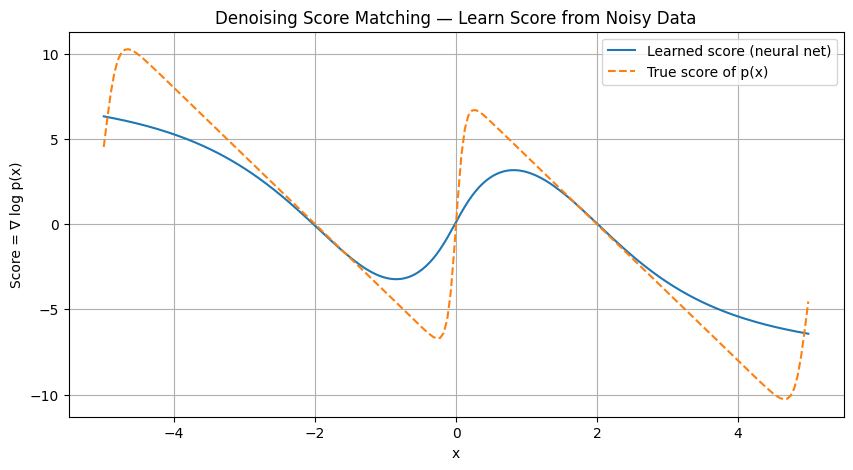

In [ ]:
def true_score(x_grid):
    pdf1 = np.exp(-0.5 * ((x_grid + 2) / 0.5)**2) / (0.5 * np.sqrt(2*np.pi))
    pdf2 = np.exp(-0.5 * ((x_grid - 2) / 0.5)**2) / (0.5 * np.sqrt(2*np.pi))
    p = 0.5 * pdf1 + 0.5 * pdf2
    dp = -(x_grid + 2)/(0.5**2) * pdf1 * 0.5 + -(x_grid - 2)/(0.5**2) * pdf2 * 0.5
    score = dp / (p + 1e-8) # ∇log(p(x)) = p'(x)/p(x)
    return score

# Plot
x_grid = np.linspace(-5, 5, 200).reshape(-1, 1)
x_tensor = torch.tensor(x_grid, dtype=torch.float32)
with torch.no_grad():
    pred_score = model(x_tensor).numpy()

plt.figure(figsize=(10, 5))
plt.plot(x_grid, pred_score, label='Learned score (neural net)')
plt.plot(x_grid, true_score(x_grid), label='True score of p(x)', linestyle='--')
plt.title("Denoising Score Matching — Learn Score from Noisy Data")
plt.xlabel("x")
plt.ylabel("Score = ∇ log p(x)")
plt.grid()
plt.legend()
plt.show()

### lets sample now the learned distribution using langvin sampling

* xt+1 = x + e/2 * s(x) + np.sqrt(e) * N(0,1)

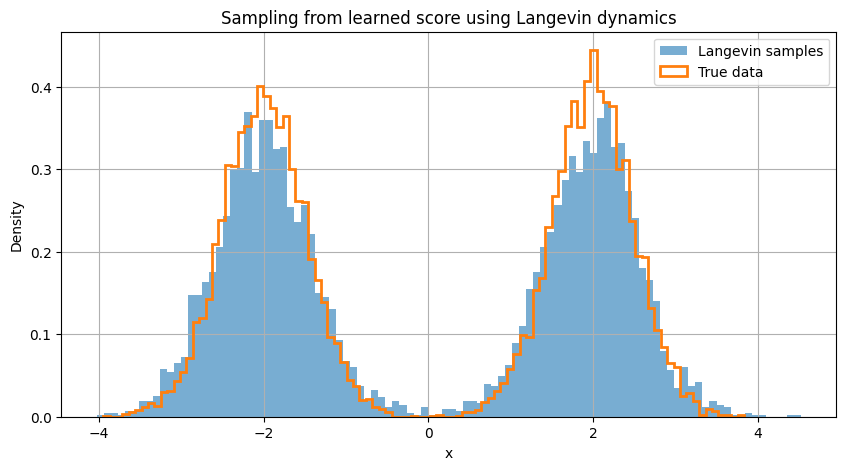

In [ ]:
epsilon=0.01
def langevin_sample(model, n_samples=1000, n_steps=100, epsilon=0.1):
    model.eval()
    x = torch.randn(n_samples, 1)  # initiazes all n samples as single tensor eg: (1000,1)

    for _ in range(n_steps):
        x_detached = x.detach() # Detach x , create a copy of x with any gradient history, ie any operation is not tracked
        score = model(x_detached)
        noise = torch.randn_like(x)
        x = x + 0.5 * epsilon * score + np.sqrt(epsilon) * noise # (1000,1)

    return x.detach().numpy()

# Generate samples from the learned score
samples = langevin_sample(model, n_samples=5000, n_steps=100, epsilon=0.1)

# Plot generated samples vs. true distribution
true = sample_data(10000)

plt.figure(figsize=(10, 5))
plt.hist(samples, bins=100, density=True, alpha=0.6, label='Langevin samples')
plt.hist(true, bins=100, density=True, histtype='step', linewidth=2, label='True data')
plt.title("Sampling from learned score using Langevin dynamics")
plt.xlabel("x")
plt.ylabel("Density")
plt.grid()
plt.legend()
plt.show()

shape of true sample:  (10000, 2)


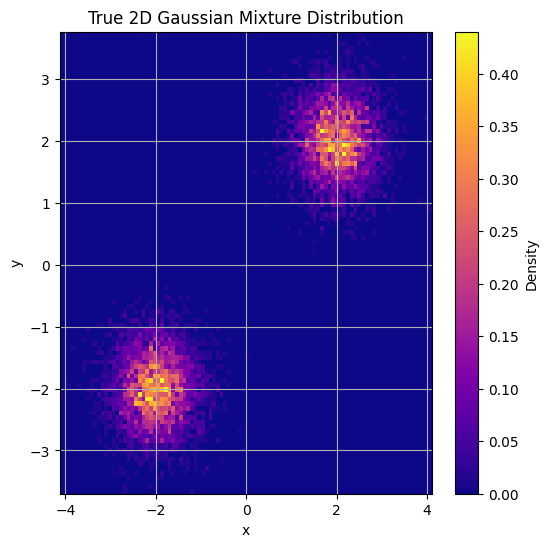

In [4]:
# 2D case
# Define a 2D Gaussian mixture distribution
def sample_2d_data(n):
    means = [np.array([-2, -2]), np.array([2, 2])]
    samples = []
    for _ in range(n):
        if np.random.rand() < 0.5:
            samples.append(np.random.randn(2) * 0.5 + means[0])
        else:
            samples.append(np.random.randn(2) * 0.5 + means[1])
    return np.array(samples)

# Sample from the true distribution
true_samples = sample_2d_data(10000)
print(f"shape of true sample: ", true_samples.shape)

# Visualize the true distribution
plt.figure(figsize=(6, 6))
plt.hist2d(true_samples[:, 0], true_samples[:, 1], bins=100, density=True, cmap='plasma')
plt.colorbar(label='Density')
plt.title('True 2D Gaussian Mixture Distribution')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()



In [ ]:
# Now add noise to it: the sample:
X = sample_2d_data(10000)
sigma = 0.2
noise = np.random.randn(*X.shape)*sigma
X_noisy = X + noise # add noise to all Xs

target = (X - X_noisy)/sigma**2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

X_noisy_tensor = torch.tensor(X_noisy, dtype = torch.float32)
target_tensor = torch.tensor(target, dtype=torch.float32)

dataset = TensorDataset(X_noisy_tensor, target_tensor)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

# Define score model (MLP)
class ScoreNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        return self.net(x)

model = ScoreNet()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [ ]:
# Training loop
epochs = 50
for epoch in range(epochs):
    total_loss = 0
    for x_batch , target_batch in loader:
        pred = model(x_batch)
        loss = loss_fn(pred, target_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1} , Loss : {total_loss:.4f}")

Epoch 1 , Loss : 1877.6633
Epoch 2 , Loss : 1808.9541
Epoch 3 , Loss : 1747.3154
Epoch 4 , Loss : 1726.7316
Epoch 5 , Loss : 1712.4066
Epoch 6 , Loss : 1717.3304
Epoch 7 , Loss : 1710.8298
Epoch 8 , Loss : 1713.3768
Epoch 9 , Loss : 1722.4740
Epoch 10 , Loss : 1714.9985
Epoch 11 , Loss : 1711.5922
Epoch 12 , Loss : 1707.6086
Epoch 13 , Loss : 1719.0720
Epoch 14 , Loss : 1714.7983
Epoch 15 , Loss : 1713.9197
Epoch 16 , Loss : 1717.7468
Epoch 17 , Loss : 1715.3367
Epoch 18 , Loss : 1710.9511
Epoch 19 , Loss : 1714.7245
Epoch 20 , Loss : 1714.4686
Epoch 21 , Loss : 1711.7804
Epoch 22 , Loss : 1712.7940
Epoch 23 , Loss : 1708.7397
Epoch 24 , Loss : 1714.9912
Epoch 25 , Loss : 1721.2668
Epoch 26 , Loss : 1711.0589
Epoch 27 , Loss : 1717.3155
Epoch 28 , Loss : 1711.6614
Epoch 29 , Loss : 1715.1202
Epoch 30 , Loss : 1711.2091
Epoch 31 , Loss : 1704.3537
Epoch 32 , Loss : 1701.1384
Epoch 33 , Loss : 1712.0922
Epoch 34 , Loss : 1709.3690
Epoch 35 , Loss : 1707.9715
Epoch 36 , Loss : 1708.2862
E

shape of generated sample:  (10000, 2)


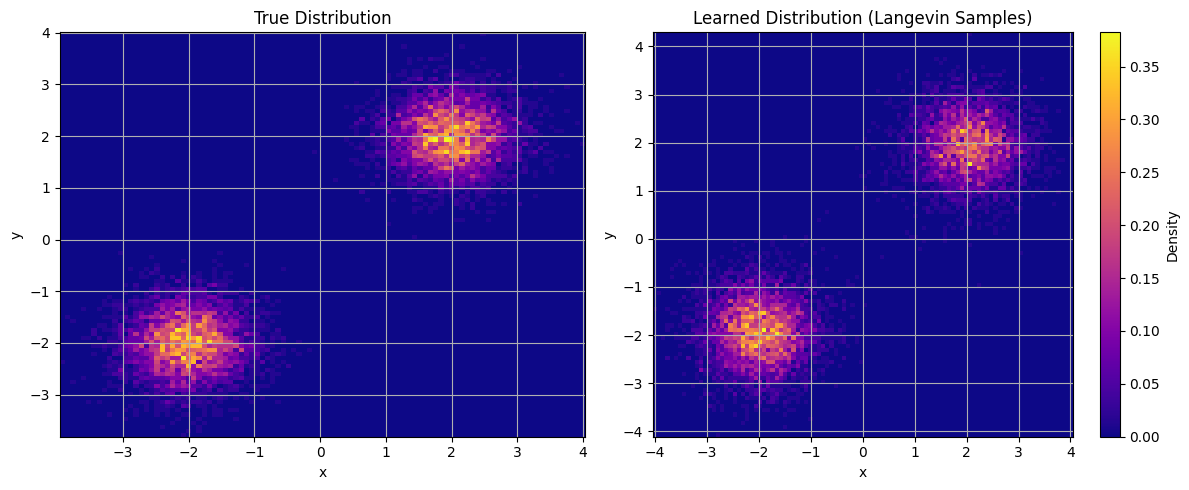

In [ ]:
def langevin_sample_2d(model, n_samples=1000, n_steps=100, epsilon=0.1):
    model.eval()
    x = torch.randn(n_samples, 2)  # Start from noise

    for _ in range(n_steps):
        x_detached = x.detach()  # Stop gradients from accumulating
        score = model(x_detached)
        noise = torch.randn_like(x)
        x = x + 0.5 * epsilon * score + np.sqrt(epsilon) * noise

    return x.detach().numpy()

generated_samples = langevin_sample_2d(model, n_samples=10000, n_steps=100, epsilon=0.1)
print(f"shape of generated sample: ", generated_samples.shape)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# True
true_hist = axes[0].hist2d(true_samples[:, 0], true_samples[:, 1], bins=100, density=True, cmap='plasma')
axes[0].set_title("True Distribution")
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
axes[0].grid(True) # Add grid to the first subplot

# Sampled
sampled_hist = axes[1].hist2d(generated_samples[:, 0], generated_samples[:, 1], bins=100, density=True, cmap='plasma')
axes[1].set_title("Learned Distribution (Langevin Samples)")
axes[1].set_xlabel("x")
axes[1].set_ylabel("y")
axes[1].grid(True) # Add grid to the second subplot

plt.tight_layout()
plt.colorbar(sampled_hist[3], ax=axes[1], label='Density') # Pass the mappable object to colorbar
plt.show()

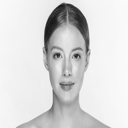

In [ ]:
# Now lets try to learn the distribution of a single image
# here in this case of one image trainign each pixel is a sample
from PIL import Image
img = Image.open('face_1.jpg').convert('L')
img = img.resize((128,128))
display(img)

In [18]:
from PIL import Image
import torchvision.transforms as T

img = Image.open('face_1.jpg').convert('L')
transform = T.Compose([
    T.Resize((128,128)),
    T.ToTensor(), # Converts to tensor in range [0, 1]
])

x = transform(img)
print(x.shape)

torch.Size([1, 128, 128])


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

x0 = x.to(torch.float32).unsqueeze(0) # (1,1,128,128)
sigma = 0.1

# Generate noisy version
x_noisy = x0 + sigma * torch.randn_like(x0)
target = -(x_noisy - x0) / (sigma ** 2)

class ConvScoreNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 1, 3, padding=1)  # Predicts per-pixel score
        )

    def forward(self, x):
        return self.net(x)


In [20]:
model = ConvScoreNet().to(x0.device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

n_epochs = 1000

for epoch in range(n_epochs):
    # Re-noise every time to avoid overfitting
    x_noisy = x0 + sigma * torch.randn_like(x0) # train over multiple epochs with augmented noise since x0 is single sample
    target = -(x_noisy - x0) / (sigma ** 2)

    pred = model(x_noisy)
    loss = loss_fn(pred, target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

Epoch 0, Loss: 98.497299
Epoch 50, Loss: 13.684812
Epoch 100, Loss: 10.129849
Epoch 150, Loss: 8.088956
Epoch 200, Loss: 7.238153
Epoch 250, Loss: 6.931310
Epoch 300, Loss: 6.804816
Epoch 350, Loss: 6.121218
Epoch 400, Loss: 6.347800
Epoch 450, Loss: 6.256735
Epoch 500, Loss: 6.109952
Epoch 550, Loss: 5.879207
Epoch 600, Loss: 5.200449
Epoch 650, Loss: 5.857107
Epoch 700, Loss: 5.433937
Epoch 750, Loss: 5.007710
Epoch 800, Loss: 5.079799
Epoch 850, Loss: 5.000610
Epoch 900, Loss: 5.307400
Epoch 950, Loss: 5.178122


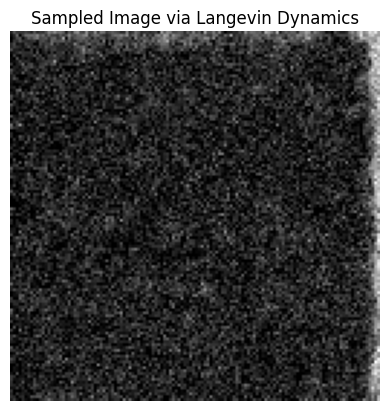

In [21]:
# Now lets try to sample this distribution
def langevin_sample(model, shape=(1,128,128), n_steps = 1000, epsilon=0.01):
    model.eval()
    x = torch.randn(shape).to(next(model.parameters()).device)

    for _ in range(n_steps):
        x = x.detach().requires_grad_()
        score = model(x)
        noise = torch.randn_like(x)
        x = x + 0.5 * epsilon * score + torch.sqrt(torch.tensor(epsilon)) * noise

        # Optional: clamp pixel range to [0, 1] if training assumed that
        x = x.clamp(0.0, 1.0)
    return x.detach()

sample = langevin_sample(model, shape=(1, 128, 128), n_steps=100, epsilon=0.01)
plt.imshow(sample.squeeze().cpu(), cmap='gray')
plt.title("Sampled Image via Langevin Dynamics")
plt.axis('off')
plt.show()

Here in this case we use same step size for each pixel, and same sigma for each pixel , which is not correct at some point, because,some pixels may reach the mean faster , and some maynot. so to get all the pixels to correct distribution, then we have to update the stepsize depends on some other metric. and same for sigma

* One thing to notice here is that, in the forward pass , we added noise only one time (which is even not noticable),
* and we try to denoise (langvin sampling) it from pure noise in the backward process to the desired distribution
* in low dimensions, a single noise level still allows the model to generalize well, there's not much space to cover
* the score can pull samples even from far regions in a small spaces

### New Approach
we use multiple noise scales during training
*  $$
x_t = x_0 + \sigma \epsilon, \quad \epsilon \sim \mathcal{N}(0, I), \quad \sigma \in \{\sigma_1, \sigma_2, \dots, \sigma_n\}
$$
* train a NN to learn score
  * $$
\text{For all noise levels } \sigma: \\
\nabla_x \log p_\sigma(x) = -\frac{\epsilon_\sigma(x)}{\sigma} \\
\text{where } x = x_0 + \sigma\epsilon, \epsilon \sim \mathcal{N}(0,I)
$$

### Training details
we train the model using multiple noise leve, where each input is ..
* Xσ = X0 + σ . ϵ
- the NN needs to know what noise level σ was applied to make the correct prediction. so we condition the model on σ
- INPUT size to NN = ((shape of i/p), sigma)
  * if i/p ➡ [x1,x2] , o/p ➡ ∇xlogP(x) ∈ R^2


  * Loss $$
\mathcal{L} = \mathbb{E}_{x_0, \sigma, \epsilon} \left[ \left\| s(x_0 + \sigma \epsilon, \sigma) + \frac{\epsilon}{\sigma} \right\|^2 \right]
$$


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ScoreNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2 + 1, 128),  # input: [x, sigma]
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 2)       # output: gradient w.r.t x (2D)
        )

    def forward(self, x, sigma):
        sigma_input = sigma.view(-1, 1)  # ensure shape [B,1]
        x_sigma = torch.cat([x, sigma_input], dim=1)
        return self.net(x_sigma)

In [42]:
# Training
import imageio
import os

# Directory to save frames
os.makedirs("frames", exist_ok=True)
frame_paths = []

X = sample_2d_data(10000)
print(X.shape)
x0 = torch.tensor(X, dtype = torch.float32)

# setup
model = ScoreNet()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
sigmas = torch.tensor(np.exp(np.linspace(np.log(0.01), np.log(1.0), 10)), dtype=torch.float32)

# Langevin sampling function
@torch.no_grad()
def langevin_sample(model, n_samples=1000, n_steps=100, epsilon=0.1, sigma_min=0.01):
    x = torch.randn(n_samples, 2)  # random noise

    for _ in range(n_steps):
        sigma = torch.full((n_samples,), sigma_min)
        grad = model(x, sigma)
        noise = torch.randn_like(x)
        x = x + 0.5 * epsilon * grad + torch.sqrt(torch.tensor(epsilon)) * noise

    return x.numpy()

# Training
for epoch in range(10000):
    idx = torch.randint(0, x0.shape[0], (128,))
    x_clean = x0[idx]
    sigma = sigmas[torch.randint(0, len(sigmas), (128,))]

    noise = torch.randn_like(x_clean) * sigma.view(-1,1)
    x_noisy = x_clean + noise
    target = - noise / sigma.view(-1,1)**2

    pred = model(x_noisy, sigma)
    loss = loss_fn(pred, target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

        # Sampling and Visualization
        samples = langevin_sample(model, n_samples=1000, n_steps=100, epsilon=0.1, sigma_min=0.01)

        # Save plot as image
        fig, ax = plt.subplots(figsize=(6,6))
        ax.hist2d(samples[:, 0], samples[:, 1], bins=100, density=True, cmap='plasma')
        ax.set_title(f"Epoch {epoch}")
        ax.grid(True)

        fname = f"frames/frame_{epoch:05d}.png"
        plt.savefig(fname)
        plt.close(fig)
        frame_paths.append(fname)


(10000, 2)
Epoch 0, Loss: 1266.0061
Epoch 500, Loss: 1399.7568
Epoch 1000, Loss: 1367.9297
Epoch 1500, Loss: 2030.8667
Epoch 2000, Loss: 2259.0549
Epoch 2500, Loss: 1644.6394
Epoch 3000, Loss: 1322.1255
Epoch 3500, Loss: 1713.1110
Epoch 4000, Loss: 1092.4899
Epoch 4500, Loss: 778.3334
Epoch 5000, Loss: 1417.4812
Epoch 5500, Loss: 1099.4685
Epoch 6000, Loss: 2839.4336
Epoch 6500, Loss: 1549.6428
Epoch 7000, Loss: 1282.7335
Epoch 7500, Loss: 1494.7589
Epoch 8000, Loss: 1271.0762
Epoch 8500, Loss: 2144.6208
Epoch 9000, Loss: 2194.9180
Epoch 9500, Loss: 1963.8396


/tmp/ipython-input-54-2526100023.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(fname)


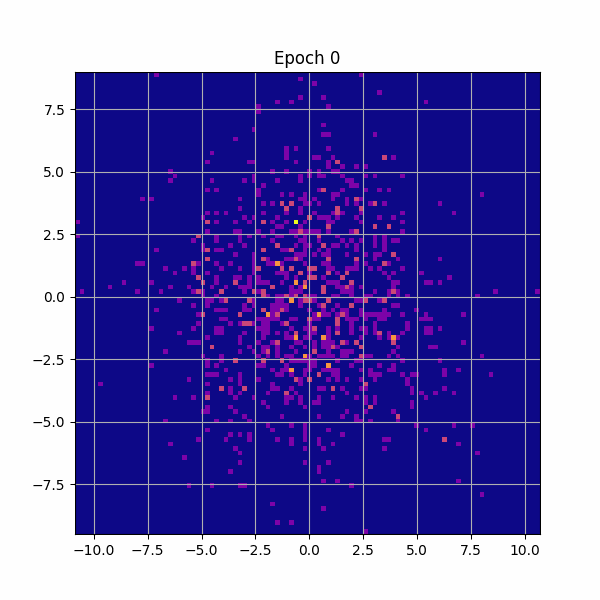

In [54]:
from IPython.display import Image, display
with imageio.get_writer('langevin_training.gif', mode='I', duration=1) as writer:
    for fname in frame_paths:
        image = imageio.imread(fname)
        writer.append_data(image)

if os.path.exists("langevin_training.gif"):
    display(Image(filename="langevin_training.gif"))
else:
    print("GIF not found!")


### Now progressive noise addition
$$x_t = \sqrt{\bar{\alpha}_t} \cdot x_0 + \sqrt{1 - \bar{\alpha}_t} \cdot \epsilon$$
* Train a score network $$
s_\theta(x_t, t) \approx \nabla_{x_t} \log p(x_t)
$$
  - $$
\begin{aligned}
&\text{The score of a Gaussian distribution } x_t \sim \mathcal{N}(\sqrt{\bar{\alpha}_t}x_0, (1-\bar{\alpha}_t)\mathbf{I}) \text{ is:} \\
&\nabla_{x_t} \log p(x_t|x_0) = -\frac{1}{1-\bar{\alpha}_t}(x_t - \sqrt{\bar{\alpha}_t}x_0) \\
\\
&\text{Plugging in } x_t = \sqrt{\bar{\alpha}_t}x_0 + \sqrt{1-\bar{\alpha}_t}\epsilon, \text{ we get:} \\
&\nabla_{x_t} \log p(x_t|x_0) = -\frac{\epsilon}{\sqrt{1-\bar{\alpha}_t}}
\end{aligned}
$$

* Reverse Process (sampling)
  * use Langevin dynamics, guided by the learned score at each timestep $$s_\theta(x_t, t)$$ , to gradually denoise from pure noise to data

Loss function = $$
\mathcal{L} = \mathbb{E}_{t \sim \text{Uniform}(1,T)} \left[ \mathbb{E}_{\mathbf{x}_0, \epsilon} \left\| \text{ScoreNet}(\mathbf{x}_t, t) + \frac{\epsilon}{\sqrt{1-\bar{\alpha}_t}} \right\|^2 \right]
$$

Reverse process:
1. Start from:
$$
\mathbf{x}_T \sim \mathcal{N}(0, I)
$$

2. For each timestep $t = T,...,1$:

* Estimate the score $\nabla \log p_t(\mathbf{x}_t) \approx s_\theta(\mathbf{x}_t, t)$

* Update:
$$
\mathbf{x}_{t-1} = \mathbf{x}_t + \frac{\epsilon}{2} \cdot s_\theta(\mathbf{x}_t, t) + \sqrt{2\epsilon} \cdot \mathcal{N}(0, I)
$$

So:

"denoise" iteratively, using learned scores.

The learned score tells you the direction of increasing likelihood, just like gradient ascent in latent space.

In [6]:
# Now lets apply progressive defusing of noise instead of random noise addition

# Training
import imageio
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:" , device)
# Directory to save frames
os.makedirs("frames_pg", exist_ok=True)
frame_paths = []

X = sample_2d_data(10000)
print(X.shape)
x0 = torch.tensor(X, dtype = torch.float32).to(device)

# setup
model = ScoreNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
T= 1000 # number of diffustion steps
betas = torch.linspace(1e-4, 0.2,T)
alphas = 1. - betas
alpha_bars = torch.cumprod(alphas, dim=0) # cumulative product of alphas for different noise level
alpha_bars = alpha_bars.to(device)

# Langevin sampling function
@torch.no_grad()
def langevin_sample(model, n_samples=1000, n_steps=100, eps=0.1):
    x = torch.randn(n_samples, 2, device=device)  # random noise

    for t in reversed(range(T)):
      t_tensor = torch.full((n_samples,), t, dtype=torch.long, device=device)
      for _ in range(n_steps):  # Langevin steps at fixed t
              grad = model(x, t_tensor)
              noise = torch.randn_like(x)
              x = x + 0.5 * eps**2 * grad + eps * noise
    return x.cpu().numpy()

# Training
for epoch in range(10000):

    idx = torch.randint(0, x0.shape[0], (128,), device=device)
    x_clean = x0[idx]

    #Proper timestep sampling
    t = torch.randint(0, T, (128,), dtype=torch.long, device=device)
    alpha_bar_t = alpha_bars[t].view(-1,1)

    noise = torch.randn_like(x_clean, device=device)
    x_noisy = x_clean * alpha_bar_t.sqrt() + noise * (1 - alpha_bar_t).sqrt()

    target = -noise / (1 - alpha_bar_t).sqrt()

    # Use t as time conditioning
    pred = model(x_noisy, t)

    loss = loss_fn(pred, target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

        # Sampling and Visualization
        samples = langevin_sample(model, n_samples=1000, n_steps=100, eps=0.1)

        # Save plot as image
        fig, ax = plt.subplots(figsize=(6,6))
        ax.hist2d(samples[:, 0], samples[:, 1], bins=100, density=True, cmap='plasma')
        ax.set_title(f"Epoch {epoch}")
        ax.grid(True)

        fname = f"frames_pg/frame_{epoch:05d}.png"
        plt.savefig(fname)
        plt.close(fig)
        frame_paths.append(fname)


device: cuda
(10000, 2)
Epoch 0, Loss: 14.3205
Epoch 500, Loss: 121.5119
Epoch 1000, Loss: 25.0005
Epoch 1500, Loss: 10.5831
Epoch 2000, Loss: 13.7298
Epoch 2500, Loss: 47.0682
Epoch 3000, Loss: 1.3179
Epoch 3500, Loss: 0.4649
Epoch 4000, Loss: 38.9089
Epoch 4500, Loss: 0.9464
Epoch 5000, Loss: 1.6673
Epoch 5500, Loss: 0.6446
Epoch 6000, Loss: 2.0109
Epoch 6500, Loss: 0.2772
Epoch 7000, Loss: 6.0480
Epoch 7500, Loss: 13.4728
Epoch 8000, Loss: 3.0377
Epoch 8500, Loss: 44.7089
Epoch 9000, Loss: 0.2261
Epoch 9500, Loss: 5.6449


/tmp/ipython-input-10-2236903766.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(fname)


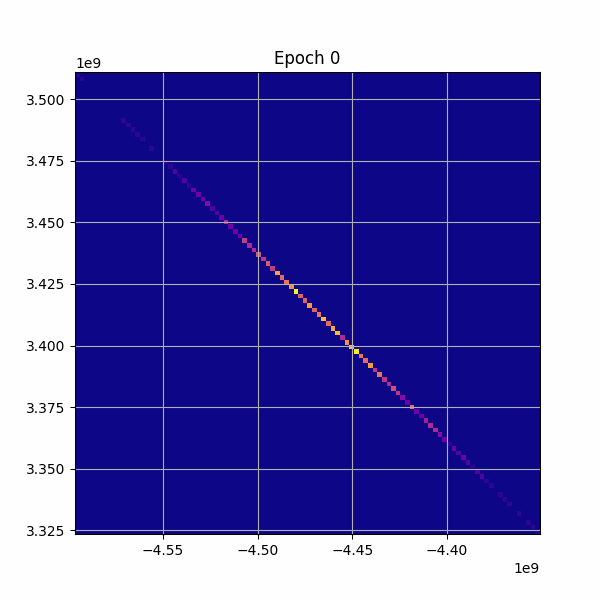

In [10]:
from IPython.display import Image, display
with imageio.get_writer('diffusion_training.gif', mode='I', duration=1) as writer:
    for fname in frame_paths:
        image = imageio.imread(fname)
        writer.append_data(image)

if os.path.exists("diffusion_training.gif"):
    display(Image(filename="diffusion_training.gif"))
else:
    print("GIF not found!")


* The result shows its not capturing full structure of 2D guassian mixture, particularly , there is an unnatural spread towards the right
* like issue:
  * Time/Sigma Conditioning Is Too Weak
  * Langevin Sampling with Same Step Size
  * No Weight Normalization or LayerNorm

Feeding time as float to NN is not good, as it struggle to understand it meaning, so a single number provides very limited information to the network

The time embedding transforms a scalar timestep $t$ into a high-dimensional vector representation using sinusoidal positional encoding:


\begin{aligned}
\omega &= \frac{\log(10000)}{h - 1} \\
e_i &= \exp(-i \cdot \omega) \quad \text{for} \quad i \in \{0, 1, \ldots, h - 1\} \\
\text{emb}_i &=
\begin{cases}
\sin(t \cdot e_i) & \text{if } i < h \\
\cos(t \cdot e_{i-h}) & \text{if } h \leq i < d
\end{cases}
\end{aligned}


**Where:**
- $\omega$ controls the frequency progression
- $e_i$ gives exponentially decreasing wavelengths
- The final embedding concatenates sine and cosine components ($d = 2h$)

This is followed by a small MLP for feature transformation:

In [12]:
class TimeEmbedding(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.linear2 = nn.Linear(128, 128)

    def forward(self, t):
        half_dim = 64
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim) * -emb).to(t.device)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
        return F.relu(self.linear2(F.relu(self.linear1(emb))))

class ScoreNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_emb = TimeEmbedding(embedding_dim=128)
        self.fc1 = nn.Linear(2 + 128, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x, t):
        t_emb = self.time_emb(t)
        x_input = torch.cat([x, t_emb], dim=1)
        h = F.relu(self.fc1(x_input))
        h = F.relu(self.fc2(h))
        return self.fc3(h)


In [13]:
# Now lets apply progressive defusing of noise instead of random noise addition

# Training
import imageio
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:" , device)
# Directory to save frames
os.makedirs("frames_pg", exist_ok=True)
frame_paths = []

X = sample_2d_data(10000)
print(X.shape)
x0 = torch.tensor(X, dtype = torch.float32).to(device)

# setup
model = ScoreNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
T= 1000 # number of diffustion steps
betas = torch.linspace(1e-4, 0.2,T)
alphas = 1. - betas
alpha_bars = torch.cumprod(alphas, dim=0) # cumulative product of alphas for different noise level
alpha_bars = alpha_bars.to(device)

# Langevin sampling function
@torch.no_grad()
def langevin_sample(model, n_samples=1000, n_steps=100, eps=0.1):
    x = torch.randn(n_samples, 2, device=device)  # random noise

    for t in reversed(range(T)):
      t_tensor = torch.full((n_samples,), t, dtype=torch.long, device=device)
      for _ in range(n_steps):  # Langevin steps at fixed t
              grad = model(x, t_tensor)
              noise = torch.randn_like(x)
              sigma_t = (1 - alpha_bars[t]).sqrt() # instead of fixed eps, its scaled by sigma
              eps_t = 0.1* sigma_t.view(-1,1)
              x = x + 0.5 * eps_t**2 * grad + eps_t * noise
    return x.cpu().numpy()

# Training
for epoch in range(10000):

    idx = torch.randint(0, x0.shape[0], (128,), device=device)
    x_clean = x0[idx]

    #Proper timestep sampling
    t = torch.randint(0, T, (128,), dtype=torch.long, device=device)
    alpha_bar_t = alpha_bars[t].view(-1,1)

    noise = torch.randn_like(x_clean, device=device)
    x_noisy = x_clean * alpha_bar_t.sqrt() + noise * (1 - alpha_bar_t).sqrt()

    target = -noise / (1 - alpha_bar_t).sqrt()

    # Use t as time conditioning
    pred = model(x_noisy, t)

    loss = loss_fn(pred, target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

        # Sampling and Visualization
        samples = langevin_sample(model, n_samples=1000, n_steps=100, eps=0.1)

        # Save plot as image
        fig, ax = plt.subplots(figsize=(6,6))
        ax.hist2d(samples[:, 0], samples[:, 1], bins=100, density=True, cmap='plasma')
        ax.set_title(f"Epoch {epoch}")
        ax.grid(True)

        fname = f"frames_pg/frame_{epoch:05d}.png"
        plt.savefig(fname)
        plt.close(fig)
        frame_paths.append(fname)


device: cuda
(10000, 2)
Epoch 0, Loss: 4.3184
Epoch 500, Loss: 0.3079
Epoch 1000, Loss: 3.2409
Epoch 1500, Loss: 1.8147
Epoch 2000, Loss: 1.2673
Epoch 2500, Loss: 5.0571
Epoch 3000, Loss: 5.8714
Epoch 3500, Loss: 13.5851
Epoch 4000, Loss: 1.3332
Epoch 4500, Loss: 5.4823
Epoch 5000, Loss: 1.2335
Epoch 5500, Loss: 1.1817
Epoch 6000, Loss: 33.2416
Epoch 6500, Loss: 19.8773
Epoch 7000, Loss: 0.4496
Epoch 7500, Loss: 0.6539
Epoch 8000, Loss: 0.3016
Epoch 8500, Loss: 1.0031
Epoch 9000, Loss: 3.6697
Epoch 9500, Loss: 6.2803


/tmp/ipython-input-16-2236903766.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(fname)


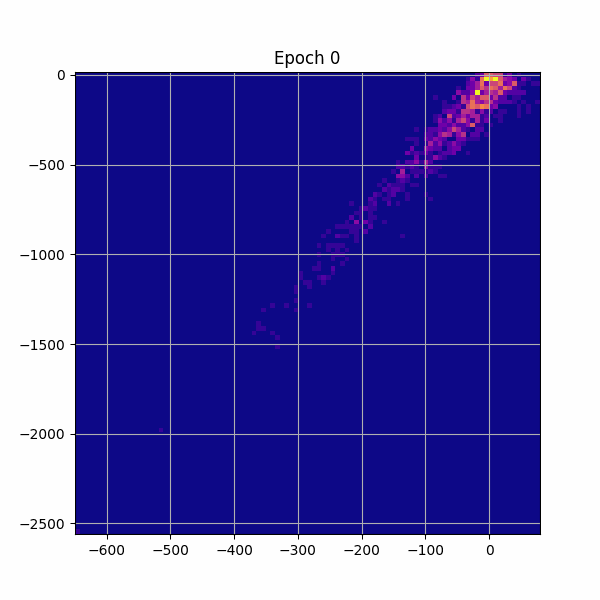

In [16]:
from IPython.display import Image, display
with imageio.get_writer('diffusion_training.gif', mode='I', duration=1) as writer:
    for fname in frame_paths:
        image = imageio.imread(fname)
        writer.append_data(image)

if os.path.exists("diffusion_training.gif"):
    display(Image(filename="diffusion_training.gif"))
else:
    print("GIF not found!")
